<a href="https://colab.research.google.com/github/TMKarunarathne/FYP/blob/main/MyResNet_Spatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ResNet

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
#from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

#from test_utils import summary, comparator
#import public_tests

%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import scipy.io
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, Flatten
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

#from test_utils import summary, comparator
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

rand_state =1000

Mounted at /content/gdrive
Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/Data_Set/FV_all_in_one.csv'
df = pd.read_csv(path)
df = df.drop(df.columns[[0]], axis=1)

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'] , unit="s")
#df.set_index(df['Datetime'] ,inplace=True)
#df = df.drop(df.columns[[0]], axis=1)
#df.head()

In [ ]:
dfdata = df.iloc[:,1:10001].to_numpy()
dfdata.shape

(8928, 10000)

In [ ]:
arr3d = dfdata.reshape(8928, 100, 100)

In [ ]:
shapeData = arr3d.shape
numInps = 5
length = shapeData[0]

In [ ]:
def shapingInputs( arr3d , numInps ):
  shapeData = arr3d.shape
  X = np.zeros(( shapeData[0]-numInps , numInps , shapeData[1] , shapeData[2] ))
  Y = arr3d[numInps :]

  for i in range(0,shapeData[0]-numInps):
    X[i] = arr3d[i:i+numInps]

  return X/2000 , Y/2000

In [ ]:
X ,Y = shapingInputs( arr3d , numInps )
print("X-shape -> ", X.shape)
print("Y-shape -> ", Y.shape)

X-shape ->  (8923, 5, 100, 100)
Y-shape ->  (8923, 100, 100)


In [ ]:
x_train = X.transpose((0,2,3,1))
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
#print(x_test.shape[0], "test samples")

x_train shape: (8923, 100, 100, 5)
8923 train samples


In [ ]:
Y1 = Y.reshape(8923, 100, 100,1)
Y1.shape

(8923, 100, 100, 1)

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
     

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut , X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [ ]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))( X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)( X_shortcut, training=training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def MyResNet(input_shape = (100, 100, 5)):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Stage 2
    # The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    # The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
    X = convolutional_block(X_input, f = 3, filters = [10, 10, 10], s = 1)
    X = identity_block(X, 3, [10, 10, 10])
    X = identity_block(X, 3, [10, 10, 10])
    X = convolutional_block(X, f = 3, filters = [10, 10, 10], s = 1)
    X = identity_block(X, 3, [10, 10, 10])
    X = identity_block(X, 3, [10, 10, 10])
    X = convolutional_block(X, f = 3, filters = [10, 10, 10], s = 1)
    X = identity_block(X, 3, [10, 10, 10])
    X = identity_block(X, 3, [10, 10, 10])
    X = Conv2D(filters = 1, kernel_size = 2, strides = (1,1), padding='same')(X)
    X = Activation('relu')(X)

    ### START CODE HERE
   

    
    # Create model
    # The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = MyResNet(input_shape = (100,100,5))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 10  60          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100, 10  40         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['MeanAbsolutePercentageError'])

In [ ]:
START = 0
END = 4000
epo = 1
batch_s = 16
model.fit(x_train[START:END], Y1[START:END], epochs = epo, batch_size = batch_s)

250/250 [==============================] - 628s 2s/step - loss: 1.4431e-04 - mean_absolute_percentage_error: 387.4660


In [ ]:
#model.save('/content/gdrive/MyDrive/Data_Set/myResNet_0111_01.model')
#model = tf.keras.models.load_model("/content/gdrive/MyDrive/Data_Set/myResNet_0111_01.model")

---
myResNet_0106_01.model ->loss: 0.0041 - mean_absolute_percentage_error: 28288.8398

myResNet_0106_02.model ->loss: 0.0036 - mean_absolute_percentage_error: 2702.2549

myResNet_0107_01.model ->loss: 2.1380e-04 - mean_absolute_percentage_error: 4670.0991

In [ ]:
pred = model.predict(x_train[7200:7200+5])

1/1 [==============================] - 2s 2s/step


In [ ]:
yout = Y1[7200:7200+5]
print('pred shape = ',pred.shape)
print('Y shape = ',yout.shape)

pred shape =  (5, 100, 100, 1)
Y shape =  (5, 100, 100, 1)


In [ ]:
def absError(y , ypred):
  i = 1
  y[np.where(y<0.0005*i)] = 0.0005*i
  dif = (np.divide( np.absolute(ypred - y) , y))/10000/ypred.shape[0]
  return np.sum(dif)

In [ ]:
print('Absolute percentage error is = ' , absError(yout , pred))

Absolute percentage error is =  0.7909165253101932


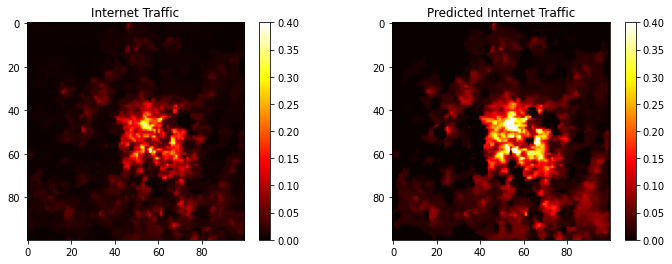

In [ ]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
Z1 = yout[0,:,:,0]
plt.imshow(Z1,cmap="hot")
plt.title("Internet Traffic")
plt.clim( 0,.4)
plt.colorbar()
#plt.show()

plt.subplot(1, 2, 2)
Z1 = pred[0,:,:,0]
plt.imshow(Z1,cmap="hot")
plt.title("Predicted Internet Traffic")
plt.clim( 0,.4)
plt.colorbar()
plt.savefig('/content/gdrive/MyDrive/Data_Set/plots_mid_2/MyResNet_Spatio_compare_2.png',transparent=True)
plt.show()


# -------------------------------------------------------------------------------